For given graph of tasks with its execution costs we calculate minimum duration for given budget.

In [1]:
graphName = "graphs/testGraph.txt"
costsName = "graphs/testGraphcosts.txt"

First we read graph from *graphName* file.

In [2]:
from collections import defaultdict

# Nodes in DAG that are represented as (node, [list of ancestor])
def getImmediateAncestors(filename):
    with open(filename, 'r') as file:
        nodes = defaultdict(list)
        
        # Dummy nodes source and super sink that are added to represent start and end of project
        sourceNodes = set()
        superSinkNodes = set()
        removeFromeSource = set()
        removeFromSuperSink = set()
        
        # Necessary representation for networkx to draw graph
        GxNodes = set()
        GxEdges = []
            
        for line in file:
            # from represented direceted edges as (node ancestor) we get all ancestors
            node, ancestor = line.split()
            
            GxEdges.append((node, ancestor))
            
            nodes[node].append(ancestor)
            sourceNodes.add(node)
            superSinkNodes.add(ancestor)
            removeFromeSource.add(ancestor)
            removeFromSuperSink.add(node)
        
        for node in removeFromeSource:
            sourceNodes.discard(node)
        for node in removeFromSuperSink:
            superSinkNodes.discard(node)
            
        nodes['s'] = list(sourceNodes)
        nodes['ss'] = [None]
        for node in superSinkNodes:
            nodes[node].append('ss')
            GxEdges.append((node, 'ss'))
        
        for s in sourceNodes:
            GxEdges.append(('s', s))
        GxNodes = list(sourceNodes)
        
#         for node in nodes:
#             print(node, nodes[node])

        # return values are directed acyclic graph represened as dictionary with nodes and their ancestors
        # and GxNodes, GxEdges which is needed representation of graph for drawing
        return nodes, GxNodes, GxEdges

In [3]:
nodes, GxNodes, GxEdges = getImmediateAncestors(graphName)

Then we get graphic representation of graph.

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def drawGraph(GxNodes, GxEdges):
    # init empty graph
    Gx = nx.Graph()
    # add starting node
    Gx.add_nodes_from('s')
    # add list of remaining nodes
    Gx.add_nodes_from(GxNodes)
    # add edges
    Gx.add_edges_from(GxEdges)
    nx.draw_networkx(Gx,node_size=900, arrows=True, arrowstyle='-|>')

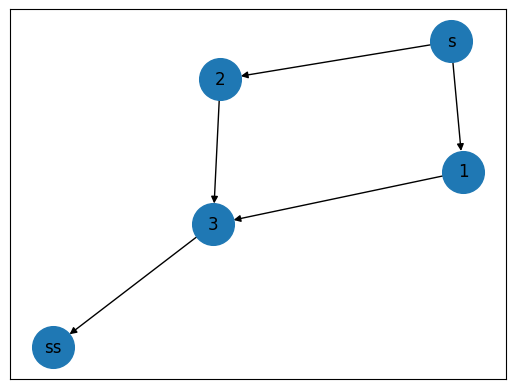

In [5]:
drawGraph(GxNodes, GxEdges)

Then we get costs for durations for each tasks

In [6]:
def getCost(filename):
    # one node represents one task, each task has array of durations with assigned costs
    # here we read thoes (duration, value) pairs and add them in dict for each node
    with open(filename, 'r') as file:
        nodes = defaultdict(list)
        currentNode = -1
        
        for line in file:
            values = line.split()
            if values[0] == 'n':
                currentNode = values[1]
                nodes[currentNode] = []
            for index in range(2, len(values)):
                duration, cost = values[index].split(',')
                duration = int(duration[1:])
                cost = int(cost[:-1])
                nodes[currentNode].append((duration, cost))

        return nodes

In [7]:
costs = getCost(costsName)
costs

defaultdict(list,
            {'1': [(2, 20), (5, 8)],
             '2': [(3, 8)],
             '3': [(1, 20), (2, 10), (4, 5)],
             's': [(0, 0)],
             'ss': [(0, 0)]})

Duration is calculated by earliest start time. Next group of tasks in order can start earliest when last task in previous group is finnished.

In [8]:
def getEarliestStartTime(nodes, solution, graph, costs, earliestStartTime):
    if nodes == []:
        return earliestStartTime
    durations = set()
    newNodes = []
#     print(nodes)
    for node in nodes:
#         print(node)
        if node == 'ss':
            durations.add(0)
            continue
        step = solution[int(node)]
        durations.add(costs[node][step][0])
        for ancestor in graph[node]:
            newNodes.append(ancestor)
    earliestStartTime += max(durations)
    return getEarliestStartTime(newNodes, solution, graph, costs, earliestStartTime)

Budget value is calculated trivially by summing costs for given execution time and given task. 

In [9]:
def budgetValue(costs, solution):
    cost = 0
    for index in range(1, len(solution)-1):
        cost += costs[str(index)][solution[index]][1]
    return cost

Brute force algorithm calculates minimal duration time of project for every possible combination of duration times for each node, then we find solution that satisfies budget.

In [10]:
import queue

def bruteForce(graph, costs, budget):
    # queue in which we will put all the combinations of durations of tasks for project
    q = queue.Queue()
    # number of nodes except source and super sink nodes which are dummy nodes
    numOfNodes = len(graph) - 2
    
    executionPlan = [0 for i in range(len(graph))]
    
    for i in range(1, numOfNodes+1):
        old = executionPlan[i]
        for step in range(len(costs[str(i)])):
            executionPlan[i] = step
            q.put(executionPlan.copy())
            for j in reversed(range(1, i)):
                oldInner = executionPlan[j]
                for step in range(len(costs[str(j)])):
                    executionPlan[j] = step
                    q.put(executionPlan.copy())
                executionPlan[j] = oldInner
        executionPlan[i] = old
        
    solutions = []
    while not q.empty():
        solution = q.get()
        duration = getEarliestStartTime(graph['s'], solution, graph, costs, 0)
        solutions.append((duration, solution.copy()))
    solutions = sorted(solutions, key = lambda x: x[0])
    for s in solutions:
        solutionBudget = budgetValue(costs, s[1])
        if solutionBudget > budget:
            continue
        else:
            minSolution = s[1]
            minDuration = s[0]
            minBudget = solutionBudget
            return minSolution, minDuration, minBudget
    raise Exception("No solution found for given budget, raise budget to get solution.") 

Brute force algorithm with cutting calculates minimal duration time of project for every possible combination of duration times for each node if it satisfy budget if it doesn't we don't calculate for that node.

In [11]:
import queue

def bruteForceBandB(graph, costs, budget):
    # queue in which we will put all the combinations of durations of tasks for project
    q = queue.Queue()
    # number of nodes except source and super sink nodes which are dummy nodes
    numOfNodes = len(graph) - 2
    
    executionPlan = [0 for i in range(len(graph))]
    
    for i in range(1, numOfNodes+1):
        old = executionPlan[i]
        for step in range(len(costs[str(i)])):
            executionPlan[i] = step
            q.put(executionPlan.copy())
            for j in reversed(range(1, i)):
                oldInner = executionPlan[j]
                for step in range(len(costs[str(j)])):
                    executionPlan[j] = step
                    q.put(executionPlan.copy())
                executionPlan[j] = oldInner
        executionPlan[i] = old
        
    minDuration = float('inf')
    minBudget = 0
    minSolution = []
    
    while not q.empty():
        solution = q.get()
        solutionBudget = budgetValue(costs, solution)
#         print(solutionBudget)
        if solutionBudget > budget:
            continue
        duration = getEarliestStartTime(graph['s'], solution, graph, costs, 0)
        if duration < minDuration:
            minDuration = duration
            minSolution = solution.copy()
            minBudget = solutionBudget
    
    if minDuration == float('inf'):
        raise Exception("No solution found for given budget, raise budget to get solution.") 
            
    return minSolution, minDuration, minBudget


Here we just got nicer output with execution time and solutions.

In [12]:
import time

def executeBruteForce(graph, costs, budget):
    start = time.perf_counter()

    try:
        minSolution, minDuration, minBudget = bruteForce(graph, costs, budget)
        print("Solution: ", minSolution)
        print("Duration: ", minDuration)
        print("Cost: ", minBudget)
    except Exception as err:
        print(err)

    end = time.perf_counter()
    executionTime = end - start

    print("Time needed for execution: " + str(executionTime))

In [13]:
import time

def executeBruteForceBandB(graph, costs, budget):
    start = time.perf_counter()

    try:
        minSolution, minDuration, minBudget = bruteForceBandB(graph, costs, budget)
        print("Solution: ", minSolution)
        print("Duration: ", minDuration)
        print("Cost: ", minBudget)
    except Exception as err:
        print(err)

    end = time.perf_counter()
    executionTime = end - start

    print("Time needed for execution: " + str(executionTime))

In [14]:
executeBruteForceBandB(nodes, costs, 30)
print()
executeBruteForce(nodes, costs, 30)

Solution:  [0, 1, 0, 1, 0]
Duration:  7
Cost:  26
Time needed for execution: 0.0007420889996865299

Solution:  [0, 1, 0, 1, 0]
Duration:  7
Cost:  26
Time needed for execution: 0.0007122930001060013


Brute force with slicing:
Solution:  [0, 1, 0, 1, 0]
Duration:  7
Cost:  26
Time needed for execution: 0.000687556999764638

Brute force:
Solution:  [0, 1, 0, 1, 0]
Duration:  7
Cost:  26
Time needed for execution: 0.0007398540001304355


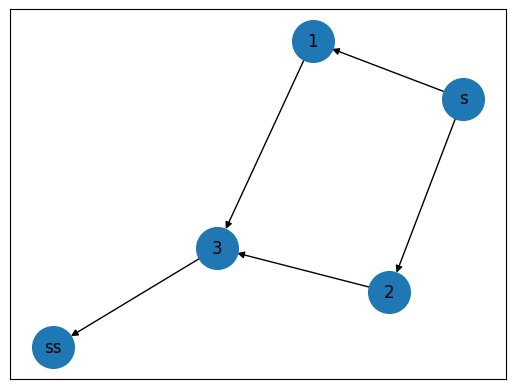

In [15]:
# graphName = "graphs/graph7.txt"
# costsName = "graphs/graph7costs.txt"
nodes, GxNodes, GxEdges = getImmediateAncestors(graphName)
costs = getCost(costsName)
budget = 30

print("Brute force with slicing:")
executeBruteForceBandB(nodes, costs, budget)

print()

print("Brute force:")
executeBruteForce(nodes, costs, budget)

drawGraph(GxNodes, GxEdges)


Solution:  [0, 1, 0, 1, 0]
Duration:  7
Cost:  26
Time needed for enumeration algorithm execution: 0.00029892399834352545

Solution:  [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Duration:  19
Cost:  9915
Time needed for enumeration algorithm execution: 0.43443990999730886

Solution:  [0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Duration:  17
Cost:  3595
Time needed for enumeration algorithm execution: 0.11979649699787842

Solution:  [0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Duration:  13
Cost:  3976
Time needed for enumeration algorithm execution: 1.324055036999198

Solution:  [0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

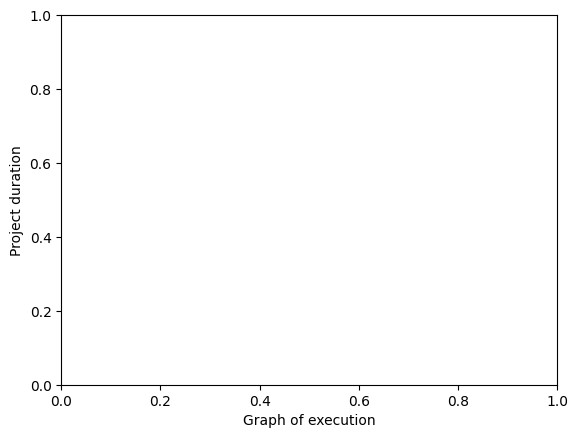

[7, 19, 17, 13, 21, 16, 13, 16, 12]


In [16]:
import time

graphNames = ["testGraph", "graph1","graph2", "graph3", "graph4", "graph5", "graph6", "graph7", "graph10"]
graphBudget = [30, 10000, 3600, 4000, 8750, 5200, 7100, 7100, 3300]

minimalDurations = []

for i in range(len(graphNames)):
    nodes, GxNodes, GxEdges = getImmediateAncestors("graphs/" + graphNames[i] + ".txt") 
    costs = getCost("graphs/" + graphNames[i] + "costs" + ".txt")

    start = time.perf_counter()
    solution, duration, projectCost = bruteForceBandB(nodes, costs, graphBudget[i])
    print("Solution: ", solution)
    print("Duration: ", duration)
    print("Cost: ", projectCost)        
    end = time.perf_counter()
    executionTime = end - start
    print("Time needed for enumeration algorithm execution: " + str(executionTime))
    minimalDurations.append(duration)

    print()
    
plt.xlabel("Graph of execution")
plt.ylabel("Project duration")
plt.show()

print(minimalDurations)